# Simulation of Birth-Death Processes (M/M/1 Queue Example)
By: Garrett Hurst

### Overview:
This notebook will walk through the M/M/1 queue Birth-Death Process and how to simulate it.

### Backgroud:
A [birth-death process](https://en.wikipedia.org/wiki/Birth%E2%80%93death_process) is a [continuous-time Markov chain](https://en.wikipedia.org/wiki/Continuous-time_Markov_chain) that models systems where the state (typically representing a population size) changes through incremental "birth" and "death" events. These processes are defined by transition rates: births increase the state by one (e.g., species speciation or customer arrivals), while deaths decrease it by one (e.g., extinction or service completions).

![BD-process.png](./BD-process.png)  
*Representation of a Birth-Death process ([citation](https://en.wikipedia.org/wiki/Birth%E2%80%93death_process))*

**Key Characteristics:**  
* **Markov Property:** Future states depend only on the current population size, not on past history
* **Transition Rates:** For a population of size $k$, births occur at rate $λ_k$ and deaths at $μ_k$
* **Exponential Waiting Times:** The time between events follows an exponential distribution

**Stationary Distribution:**  
A birth-death process has a stationary distribution iff:
$$
\sum_{N=1}^{\infty}\prod_{k=1}^N \frac{\lambda_{k-1}}{\mu_k}   < \infty
$$

The stationary distribution is:  
$$
\pi_0 = \frac{1}{ 1 + \sum_{N=1}^{\infty}\prod_{k=1}^N \frac{\lambda_{k-1}}{\mu_k}}
$$$$
\pi_k = \pi_0 \prod_{k=1}^N \frac{\lambda_{k-1}}{\mu_k}, \quad k=1, 2, ...
$$


## Simulating the M/M/1 Queue

The [M/M/1 queue](https://en.wikipedia.org/wiki/M/M/1_queue) is a birth death process where: 
$\lambda_k = \lambda,\ \mu_k = \mu \quad \forall k$.
This is a queue where a single server is processing requests one at a time. The requests come in at rate $\lambda$, and the server processes each request at rate $\mu$. The chain for the M/M/1 queue looks as follows:

![MM1_queue.png](./MM1_queue.png)  
*M/M/1 queue chain ([citation](https://en.wikipedia.org/wiki/M/M/1_queue))*

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
from functools import lru_cache

/home/x/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Define Parameters

Below are the arrival rate, service rate, and total time to run the model simulation

In [2]:
LAMBDA   = 10     # arrival rate
MU       = 20     # service rate
SIM_TIME = 50000  # total time to simulate

### Check for Stationary Distribution

**Existance of $\pi$:**  
Based on the general formula provided above, a M/M/1 queue has a stationary distribution iff:
$$
\sum_{N=1}^{\infty}\prod_{k=1}^N \frac{\lambda_{k-1}}{\mu_k} 
= \sum_{N=1}^{\infty}(\frac{\lambda}{\mu})^N  < \infty
$$
Which can be reduced to $\frac{\lambda}{\mu} < \infty$. Wehen this holds, the stationary distribution is:  
$$
\pi_0 = \frac{1}{1 + (\frac{1}{1 - \frac{\lambda}{\mu}} - 1)} = (1 - \frac{\lambda}{\mu})
$$$$
\pi_k = (1 - \frac{\lambda}{\mu})(\frac{\lambda}{\mu})^k
$$

**Calculating Error:**  
In addition to calculating the stationary distribution, a function is also defined below that takes a state occupancy meaure as a dictionary as an input and returns the L1-norm error with the stationary distribution. 

In [3]:
# check if a stationary distribution exists
has_stationary_dist = LAMBDA < MU 

# calculate stationary distribution and cache to prevent doing the calculation many times
@lru_cache(maxsize=128)
def calc_stationary(state):
    return (1 - LAMBDA/MU) * np.power(LAMBDA/MU, state)

# calculate the L1 norm for error
def calc_stationary_err(occupancy, total_time):
    err = 0
    max_n = 0
    if total_time > 0:
        max_n  = np.max(list(occupancy.keys()))
        # sum errors from the observed states
        for n in range(max_n):
            err += abs(occupancy[n]/total_time - calc_stationary(n))
    # add the remaining portion of the geometric series
    err += np.power(LAMBDA / MU, max_n + 1) / (1 - LAMBDA / MU)
    return err

### Sinulation Design (Universal Clock)
There are several ways that the chain can be simulated; I chose to simulate the chain by sampling a single exponential random variable. 

**Why this works:**  
A simple approach to simulating this chain (from nonzero states) is:
* Sample A ~ Exp($\mu$)
* Sample B ~ Exp($\lambda$)
* The transition time is min{A,B}
* The next state is argmin{A,B}

However, while this is reasonable in this example, it does not scale well for chains that have states with a many outward edges. We can take advantage of two key ideas to simplify:
* $Min\{X_1, X_2, ..., X_N\} = Exp( \sum_{n=1}^N X_n)\quad $ where $ \quad X_i \sim Exp(\beta_i)$
* $\mathbb{P}[Min\{X_1, X_2, ..., X_N\} = X_i] = \frac{\beta_i}{\sum_{n=1}^N \beta_n} \quad $ where $\quad i \in \{1, ..., N\}$

Thus, the transition time from a **nonzero** state can be sampled from Exp($\mu + \lambda$), and the transition probabilities are proportional to the rates leaving the state. 

For the zero state, sampling the transition time from Exp($\mu + \lambda$) will be too fast. Instead of sampling from a slower transitions from an Exp($\lambda$) distribution, we can slow the clock by rejecting the transition (add a 0 -> 0 transition) with probability $\frac{\lambda}{\mu + \lambda}$.

### Calculating the Discrete Time Markov Chain Transitions



In [4]:
# find the embedded DTMC transition probabilities
P_r  = np.array([LAMBDA, MU], dtype=np.float64)
P_r /= np.sum(P_r)

# take a transition
def dtmc_transition(state):
    if state == 0:
        # scaled pdf to reject transitions
        return np.random.choice([1, 0], p=P_r)
    else:
        return np.random.choice([1, -1], p=P_r)

### Running the Simulation
While simulating, the following values are obtained:
* the transition times
* the queue length at each transition
* the error between the stationary distribution and state occupancy (if applicable)

This information lets allows the queue length vs time, convergence to stationary distribution, and final error to be visualized. 

In [5]:
# values to keep track while simulating
transition_times = [0,]
queue_lengths    = [0,]
stationary_conv  = [calc_stationary_err({0:0}, 0)]
state_occupancy  = defaultdict(int)

# initial model conditions
t = 0
queue_len = 0

# simulation loop
while t < SIM_TIME:
    # get next transition
    dt = np.random.exponential(np.sum([MU, LAMBDA]))
    t += dt
    queue_len += dtmc_transition(queue_len)

    # update trackers
    state_occupancy[queue_len] += dt
    stationary_conv.append(calc_stationary_err(state_occupancy, t))
    transition_times.append(t)
    queue_lengths.append(queue_len)

### Evaluating the Simulation Results

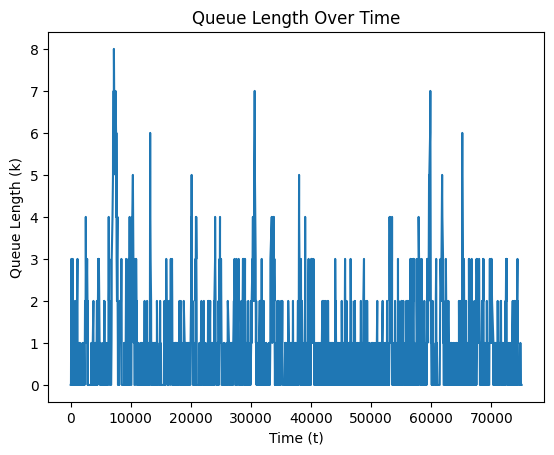

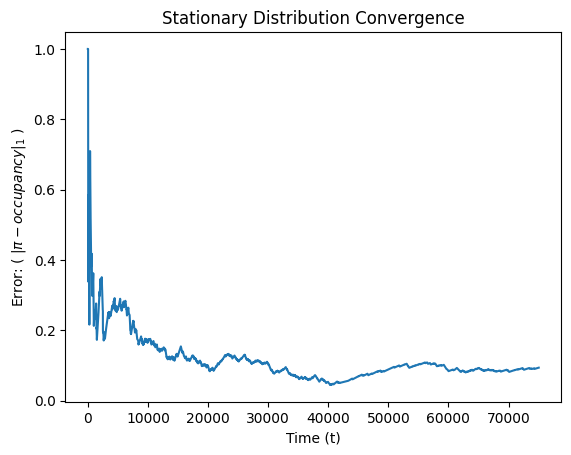

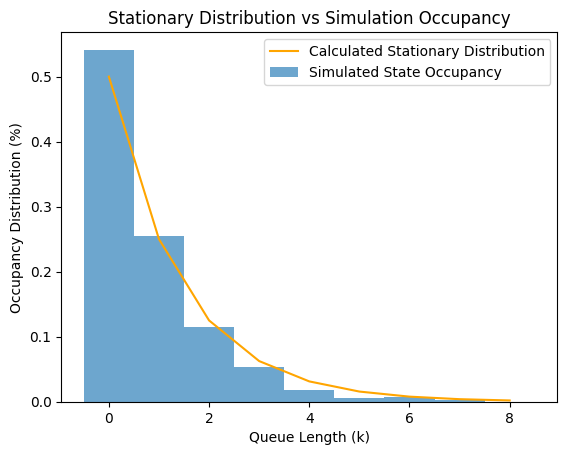

In [6]:
# show the queue length over time
plt.title('Queue Length Over Time')
plt.xlabel('Time (t)')
plt.ylabel('Queue Length (k)')
plt.plot(transition_times, queue_lengths)
plt.show()

# show the error over time
if has_stationary_dist:
    plt.title('Stationary Distribution Convergence')
    plt.xlabel('Time (t)')
    plt.ylabel('Error: ( $|\pi - occupancy|_1$ )')
    plt.plot(transition_times, stationary_conv)
    plt.show()

# final stationary distribution
states_seen = np.array(list(sorted(state_occupancy.keys())))
plt.bar(states_seen, [state_occupancy[o] / SIM_TIME for o in states_seen], width=1, alpha=0.65, label='Simulated State Occupancy')
if has_stationary_dist:
    plt.plot(states_seen, [calc_stationary(s) for s in states_seen], color='orange', label='Calculated Stationary Distribution')
plt.title('Stationary Distribution vs Simulation Occupancy')
plt.xlabel('Queue Length (k)')
plt.ylabel('Occupancy Distribution (%)')
plt.legend()
plt.show()